# Comparison between Monte Carlo algorithm, SARSA-$\lambda$ and SARSA-$\lambda$ with action-value function approximation.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns; sns.set()

from copy import deepcopy
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

## Game rules:

- The game is played with an infinite deck of cards (i.e. cards are sampled
with replacement)


- Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of _red_ (probability 1/3) or _black_ (probability
2/3).


- There are no aces or picture (face) cards in this game (no issues with usable aces!)


- At the start of the game both the player and the dealer draw one black
card (fully observed)


- Each turn the player may either **stick** or **hit**:
    - If the player hits then he draws another card from the deck
    - If the player sticks he receives no further cards and its turn ends


- The values of the player’s cards are added (if black card) or subtracted (if red
card)


- If the player’s sum exceeds 21, or becomes less than 1, then he “goes
bust” and loses the game, with a reward of -1


- If the player sticks then the dealer starts taking turns, same rules apply to him. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins, with a reward of 1; otherwise, the outcome – _win_ (reward 1),
_lose_ (reward -1), or _draw_ (reward 0) – is given by the player with the largest sum.

In [ ]:
class Jackblack():

    def __init__(self):
        """
        Init the environment with its inner variables.
        The first state by picking a random card for the dealer and player.
        """
        dealer_score, _ = self.draw_card()
        player_score, _ = self.draw_card()
        self.state = {"dealer_score": dealer_score, "player_score": player_score}  # initial state
        self.actions = ("hit", "stick")

        init_state = self.state.copy()
        self.history = [init_state]  # game history, recording state and action of each step


    def step(self, action, verbose=False):
        """
        Compute a step in Easy21 game.

        Parameters
        ----------
        action : string, the action to pick
        verbose : bool, if True actions are printed

        Returns
        -------
        state : dict, the new state reached given the picked action
        reward : int, the reward we get in this new state
        done : bool, True if state is terminal, False if not
        """
        self.history.append({"player": action})

        # player hits
        if action == "hit":
            value, colour = self.draw_card()
            self.state['player_score'] = self.compute_new_score(value, colour, self.state['player_score'])
            if verbose:
                print(f'Player draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append(new_state)

            if self.goes_bust(self.state['player_score']):
                # player goes bust
                reward = -1
                if verbose:
                    print('Player goes bust')
                    print('Player loses')
                return self.state, reward, True

            else:
                reward = 0
                return self.state, reward, False

        # player sticks
        else:
            if verbose:
                    print(f'Player stops')
            new_state = self.state.copy()
            self.history.append(new_state)

            state, reward = self.dealer_moves(verbose)
            return self.state, reward, True


    def draw_card(self):
        """
        Each draw from the deck results in a value between 1 and 10 (uniformly
        distributed) with a colour of red (probability 1/3) or black (probability 2/3).

        Returns
        -------
        value : int, the value of the card
        colour : string, the colour of the card, "red" or "black"
        """

        value = np.random.randint(low=1, high=11)
        colour = np.random.choice(['red', 'black'], p=[1/3, 2/3])
        return value, colour


    def goes_bust(self, score):
        """
        Check if the player/dealer went bust

        Parameters
        ----------
        score : int, the score to check

        Returns
        -------
        bool : True if score is outside the prescribed range
        """

        if score < 1 or score > 21:
          return True
        return False


    def compute_new_score(self, value, colour, current_score):
        """
        Compute the new score given the value and the colour of the drawn card.

        Parameters
        ----------
        value : int, the card's value
        colour : string, the card's colour
        current_score : int, the score to update

        Returns
        -------
        new_score : int, updated score
        """

        if colour == 'black':
            new_score = current_score + value
        else:
            new_score = current_score - value
        return new_score


    def dealer_moves(self, verbose=False):
        """
        Fixed dealer policy.

        Parameters
        ----------
        verbose : bool, if True actions are printed

        Returns
        -------
        state : state, the terminal state of the whole game sequence
        reward : int, the reward obtained at the end of the game sequence
        """
        # dealer hits as long as his score is < 17
        while self.state['dealer_score'] < 17:
            value, colour = self.draw_card()
            self.state['dealer_score'] = self.compute_new_score(value, colour, self.state['dealer_score'])
            if verbose:
                print(f'Dealer draws {colour} {value}')

            new_state = self.state.copy()
            self.history.append({"dealer": "hit"})
            self.history.append(new_state)


            if self.goes_bust(self.state['dealer_score']):
                # dealer goes bust, player wins
                if verbose:
                    print('Dealer goes bust')
                    print('Dealer loses')
                reward = 1
                return self.state, reward

        self.history.append({"dealer": "stick"})

        player_score = self.state['player_score']
        dealer_score = self.state['dealer_score']

        # score > 17 -> dealer sticks
        if verbose:
            print('Dealer stops')
        if dealer_score < player_score: # player wins
            reward = 1
            if verbose:
                print('Player wins')
            return self.state, reward
        if dealer_score == player_score: # draw
            reward = 0
            if verbose:
                print('Draw')
            return self.state, reward
        if dealer_score > player_score: # player loses
            reward = -1
            if verbose:
                print('Dealer wins')
            return self.state, reward


    def print_score(self):
        """
        Print the current score of the game, both for player and dealer.
        """
        print('----------------')
        for player in self.state.items():
            print(player[0] + ': ' + str(player[1]))
        print('----------------')


In [ ]:
env = Jackblack()
env.print_score()
env.step("hit", True)
env.print_score()
env.step("hit", True)
env.print_score()
env.step("stick", True)
env.print_score()

----------------
dealer_score: 2
player_score: 5
----------------
Player draws black 7
----------------
dealer_score: 2
player_score: 12
----------------
Player draws red 9
----------------
dealer_score: 2
player_score: 3
----------------
Player stops
Dealer draws red 2
Dealer goes bust
Dealer loses
----------------
dealer_score: 0
player_score: 3
----------------


## Monte-Carlo

Monte Carlo algorithm for action-value functions in order to find a good policy to win over the dealer.

The $\epsilon$-greedy policy should be implemented such that:
$$ \epsilon = \frac{N_0}{N_0 + c_1}  $$

where $c_1$ is the number of times the state has been encountered so far ($N_0$ works to set a meaningful trade-off between exploration and exploitation).



In [ ]:
class MC_Control():


    def __init__(self, N_0=100, n_episodes=100, lr=None):

        self.actions = ("hit", "stick")
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.lr = lr                    # The learning rate: "how much" the Q-function is updated at each step

        self.Q = self.init_to_zeros()   # init Q function to zeros
        self.N = self.init_to_zeros()   # init N to zeros
        self.policy = "random"          # arbitrarily init the MC learning with a random policy


    def learn_q_value_function(self):
        """
        Update the Q-function over all the episodes.

        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """

        for ep_num in range(self.n_episodes):
            if ep_num > 0: self.policy = 'e_greedy'
            episode = self.play_episode()
            total_reward = 0
            for st in episode[::-1]:#t=T-1, T-2, ..., 0
                state, action, reward, done = st
                total_reward += reward#G_(t-1) <- Gamma*G_t + R_t
                self.update_Q(state, action, total_reward)
                self.increment_counter(state, action)

        return self.Q


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}  # initialize to 0 the Q-values!

        return lookup_table


    def play_episode(self):
        """
        Run a complete (from the initial state to the terminal state) Jackblack game sequence following the given policy.

        Returns
        ----------
        episode : [(state, action, reward, done)], a list of (state, action, reward, done)
        """
        env = Jackblack()                # init a game sequence
        state = env.state.copy()         # init state
        episode = []                     # list of the steps of the game sequence
        done = False
        while not done:
            # pick an action regarding the current state and policy
            action = self.get_action(state)
            next_state, reward, done = deepcopy(env.step(action))
            step = (state, action, reward, done)  # store previous state
            state = next_state
            episode.append(step)

        return episode


    def update_Q(self, state, action, total_reward):
        """
        Update Q value towards the target.
        Even if this function does not return anything, you need to update <self.Q>!

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for that state-action pair
        """
        lookup_state = tuple(state.values())

        # The learning rate, decaying along with the number of times an action-state pair
        # has been explored. It represents the amount of modification we want to bring to
        # the Q value function.

        self.lr = 1 / (self.get_state_action_counter(state, action) + 1)#To avoid devision by zero
        current_q = self.Q[lookup_state][action]
        self.Q[lookup_state][action] = current_q + self.lr * (total_reward - current_q)

    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1


    def random_policy(self):
        """
        Return an action following a random policy (clearly state free).

        Returns
        ----------
        action : string, random action
        """

        action = np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return action


    def e_greedy_policy(self, state):
        """
        Return an action given by an epsilon greedy policy.

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """

        best_action = self.get_action_w_max_value(state)
        c1 = self.get_state_counter(state)
        eps = self.N_0 / (self.N_0 + c1)
        if np.random.rand() < eps:
            return np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return best_action


    def get_action(self, state):
        """
        Return an action following the policy prescribed by the inner value of the class (either "random" or "e_greedy").

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from prescribed policy
        """

        if self.policy == 'random':
            return self.random_policy()
        return self.e_greedy_policy(state)


    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()      # randomly breaking ties
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
            return action


    def get_state_counter(self, state):
        """
        Return the counter for a given state.

        Parameters
        ----------
        state : dict or tuple with values

        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))

        return counter


    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.

        Parameters
        ----------
        state : dict or tuple with values
        action : string

        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]

        return counter


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")

        return max_Q, df_pivot


def plot_table(table):
    """
    Plot the given value function in 3D.

    Parameters
    ----------
    table : nd-array, the value-function to be plotted
    """
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    dealer_showing = np.arange(1, 11)
    player_score = np.arange(1, 22)
    dealer_showing, player_score = np.meshgrid(dealer_showing, player_score)
    # Plot the surface.
    surf = ax.plot_surface(dealer_showing, player_score, table, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize plot
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    plt.xlabel('Dealer showing', fontsize=12)
    plt.ylabel('Player score', fontsize=12)
    plt.title('Value function', fontsize=16)
    plt.xticks(np.arange(1, 11))
    plt.yticks(np.arange(1, 22))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


In [ ]:
mc = MC_Control(n_episodes=50_000)
mc.learn_q_value_function();
mcvalue, mcpol = mc.optimal_policy()

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,hit,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
9,stick,stick,stick,hit,stick,stick,stick,stick,hit,stick


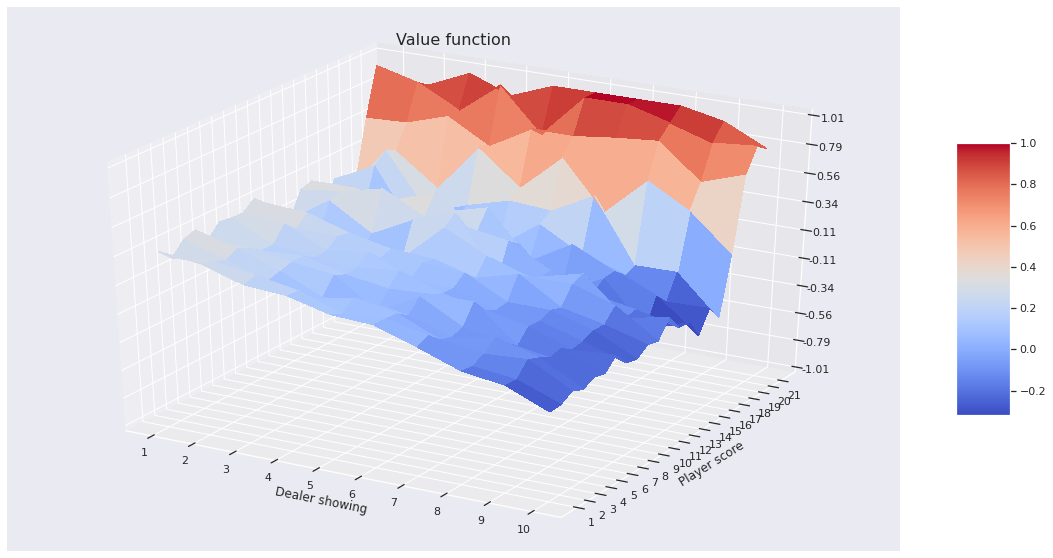

In [ ]:
display(mcpol)
plot_table(mcvalue)

## TD learning with SARSA(λ)

SARSA(λ) algorithm, using eligibility traces (both accumulating and replacing). We will have:
$$ \alpha = \frac{1}{c_2 + 1} $$

where $c_2$ is the number of times that state-action pair has been encountered so far, and alpha is the learning rate that multiplies the TD error in the update.

In [ ]:
class SARSA():


    def __init__(self, lamb=.9, N_0=100, n_episodes=100, trace="accumulating"):
        """
        Init the SARSA class with its inner variables.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick")
        self.lamb = lamb                # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes    # number of episodes (games) to sample in order to make the agent learn
        self.N_0 = N_0                  # constant parameter (influence the exploration/exploitation behavior!)
        self.trace = trace

        self.Q = self.init_to_zeros()                    # init Q function to zeros
        self.N = self.init_to_zeros()                    # init the counter traces to zeros
        self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros


    def learn_q_value_function(self):
        """
        Update the Q-function over all the episodes.

        Returns
        ----------
        Q : dictionary of dictionaries. Every state is a key, whose value is another dictionary. The latter
        dictionary's keys are the actions, and the values are the Q-values for the corresponding state-action pair.
        {state: (action)}, Q-value for every state-action pair
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = self.init_to_zeros()    # init eligibilty traces to zeros
            env = Jackblack()                                # init a game sequence
            state = env.state.copy()                         # init state
            action = self.e_greedy_policy(state)             # pick a first action
            self.increment_counter(state, action)

            done = False
            while not done:
                next_state, reward, done = deepcopy(env.step(action))

                if done:
                    next_action = None
                    delta = self.compute_delta(state, action, next_state, next_action, reward)

                else:
                    next_action = self.e_greedy_policy(next_state)
                    delta = self.compute_delta(state, action, next_state, next_action, reward)
                    self.increment_counter(next_state, next_action)
                self.increment_eligibility_traces(state, action)
                self.update_step(delta)

                action = next_action
                state = next_state

        return self.Q


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}

        return lookup_table


    def update_step(self, delta):
        """
        Update the Q value towards the target, and also the eligibility traces.

        Parameters
        ----------
        delta : float, the TD error for the current state-action pair
        """
        # Here is where the lambda parameter intervenes. The higher, the slower the eligibility trace
        # associated to a state-action will fade away.
        for st in self.Q:
            for ac in self.actions:
                c2 = self.get_state_action_counter(st, ac)
                alpha = 1 / (1 + c2)
                self.Q[st][ac] += alpha * delta * self.eligibilty_traces[st][ac]
                self.eligibilty_traces[st][ac] *= self.lamb


    def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Compute delta, the TD error.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the (e_greedy) policy

        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        if next_action is None:
            delta = reward - self.Q[lookup_state][action]
        else:
            next_lookup_state = tuple(next_state.values())
            delta = reward + self.Q[next_lookup_state][next_action] - self.Q[lookup_state][action]
        return delta


    def increment_eligibility_traces(self, state, action):
        """
        Replace or accumulate the active trace.

        Parameters
        ----------
        state : dict, active state
        action : string, active action
        """

        lookup_state = tuple(state.values())
        if self.trace == "accumulating":
            self.eligibilty_traces[lookup_state][action] += 1
        else:
            self.eligibilty_traces[lookup_state][action] = 1


    def increment_counter(self, state, action):
        """
        Increment N counter for every action-state pair encountered in an episode.

        Parameters
        ----------
        state : state, the current score
        action : string, the current score
        """
        lookup_state = tuple(state.values())
        self.N[lookup_state][action] += 1


    def random_policy(self):
        """
        Return an action following a random policy (clearly state free).

        Returns
        ----------
        action : string, random action
        """

        action = np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return action


    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy.

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """

        best_action = self.get_action_w_max_value(state)
        c1 = self.get_state_counter(state)
        eps = self.N_0 / (self.N_0 + c1)
        if np.random.rand() < eps:
            return np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return best_action


    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to Q-function
        """
        lookup_state = tuple(state.values())
        list_values = list(self.Q[lookup_state].values())
        if list_values[0] == list_values[1]:
            return self.random_policy()
        else:
            action = max(self.Q[lookup_state], key=self.Q[lookup_state].get)
            return action


    def get_state_counter(self, state):
        """
        Return the counter for a given state.

        Parameters
        ----------
        state : dict or tuple with values

        Returns
        ----------
        counter : int, the number of times a state has been explored
        """
        try:
            counter = np.sum(list(self.N[state].values()))
        except TypeError:
            lookup_state = tuple(state.values())
            counter = np.sum(list(self.N[lookup_state].values()))

        return counter


    def get_state_action_counter(self, state, action):
        """
        Return the counter for a given action-state pair.

        Parameters
        ----------
        state : dict or tuple with values
        action : string

        Returns
        ----------
        counter : int, the number of times an action-state pair has been explored
        """
        try:
            counter = self.N[state][action]
        except TypeError:
            lookup_state = tuple(state.values())
            counter = self.N[lookup_state][action]

        return counter


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = max(self.Q[states[i]], key=self.Q[states[i]].get)
            max_Q[states[i][1]-1][states[i][0]-1] = max(self.Q[states[i]].values())
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")

        return max_Q, df_pivot

In [ ]:
sarsa = SARSA(n_episodes=50_000)
sarsa.learn_q_value_function();
sarsavalue, sarsapol = sarsa.optimal_policy()

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
8,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
9,stick,stick,stick,stick,stick,stick,stick,stick,stick,hit


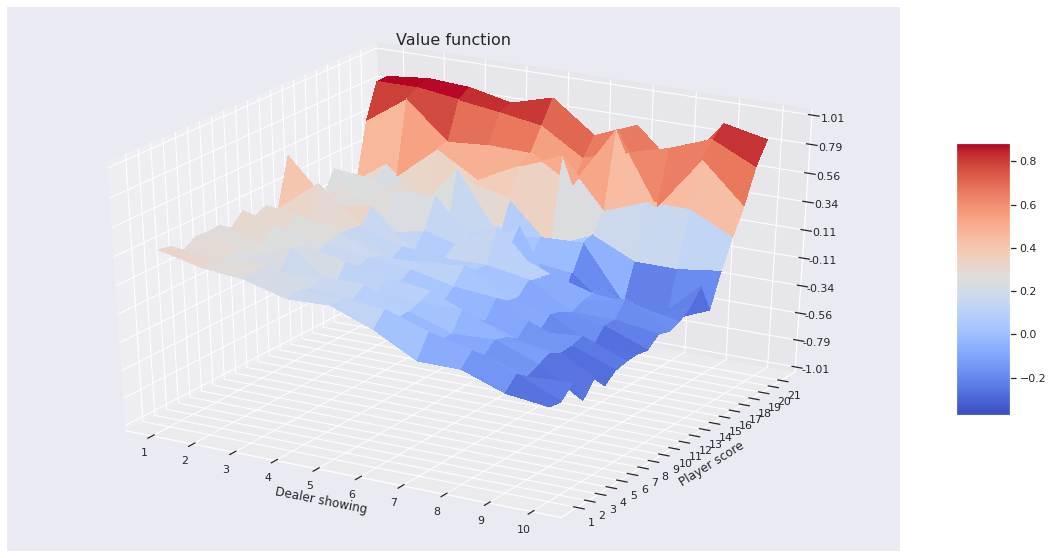

In [ ]:
display(sarsapol)
plot_table(sarsavalue)

## Linear Value Approximation

Linear approximation for the Q-function:

Linear value approximation of the SARSA(λ) algorithm, where features are overlapped. In particular, the **tile coding** for the player's sum is made of 6 features; each feature is active if the state lies in between the 2 values (extremes included):

$(1, 6), \ (4, 9), \ (7, 12), \ (10, 15), \ (13, 18), \ (16, 21)$

(there are some states in which there is more than one active feature).

In [ ]:
class Value_Approximation():


    def __init__(self, lamb=.9, epsilon=0.05, n_episodes=100, lr=0.01, trace="accumulating"):
        """
        Init the SARSA approximation class with its inner variables.
        Features are created with the given function.
        Here the epsilon and learning rate parameters are given explicitly and fixed.
        Initial weights for the linear function approximation are sampled from a Gaussian.
        Both the Q-table and the counter are initialized to zero.
        """
        self.actions = ("hit", "stick")
        self.lamb = lamb                                  # lambda parameter of the SARSA algorithm
        self.n_episodes = n_episodes                      # number of episodes (games) to sample in order to make the agent learn
        self.trace = trace

        self.features = self.create_features()                        # make features
        self.n_features = len(self.features)
        self.theta = self.init_theta()                                # init theta randomly
        self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros

        self.alpha = lr
        self.epsilon = epsilon

        # Only used for plot in optimal policy
        self.Q = self.init_to_zeros()


    def learn_q_value_function(self):
        """
        Updates the Q-function (i.e. the weights) towards the target, and also the eligibility traces.
        This function always considers the epsilon greedy policy.
        """
        for i in range(self.n_episodes):
            self.eligibilty_traces = np.zeros(self.n_features)            # init eligibilty traces to zeros
            env = Jackblack()                                             # init a game sequence
            state = env.state.copy()
            action = self.e_greedy_policy(state) # pick a first action


            while True:
                next_state, reward, done = deepcopy(env.step(action))
                next_action = self.e_greedy_policy(next_state)
                delta = self.compute_delta(state, action, next_state, next_action, reward)
                if done:
                    delta_done = reward - self.phi(tuple(state.values()), action)
                    self.update_step(delta_done, state, action)
                    break#go to the next episode
                self.update_step(delta, state, action)
                state = next_state
                action = next_action

    def init_theta(self):
        """
        Init the weights of the approximation function from a normal centered reduced gaussian distribution

        Returns
        ----------
        theta : nd-array, random weights for the approximation
        """

        mu, sigma = 0, 0.1 # mean and standard deviation
        theta = np.random.normal(mu, sigma, self.n_features)
        return theta


    def init_to_zeros(self):
        """
        Used to init the Q-function and the incremental counter N at 0 for every state-action pairs.

        Returns
        ----------
        lookup_table : {state: (action)}, a dictionary of states as keys and dictionaries as value, in which the actions
        are keys and corresponding Q-values are values
        """
        dealer_scores = np.arange(1, 11)
        player_scores = np.arange(1, 22)
        states = [(dealer_score, player_score) for player_score in player_scores for dealer_score in dealer_scores]
        lookup_table = {}
        for state in states:
            lookup_table[state] = {"hit": 0, "stick": 0}

        return lookup_table


    def create_features(self):
        """
        Create the features for linear function approximation. Overlapping tile coding.

        Returns
        ----------
        features : list of tuples, each tuple is a combination of features (dealer_feature, player_feature, action)
        """

        dealer = [(1, 4), (4, 7), (7, 10)]
        player = [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)]  # Overlapping features!
        actions = ["hit", "stick"]
        features = []
        for d in dealer:
            for p in player:
                for a in actions:
                    features.append((d, p, a))
        return features


    def update_step(self, delta, state, action):
        """
        Update the weights of the linear function towards the optimality, and also the eligibility traces.

        Parameters
        ----------
        delta : float, the TD error for the given state-action pair
        state : dict, the current state
        action : string, the current action
        """
        lookup_state = tuple(state.values())
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= lookup_state[0] <= feature[0][1]) and \
               (feature[1][0] <= lookup_state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)

        for i in index_associated_features:
            if self.trace == 'accumulating':
                self.eligibilty_traces[i] += 1
            else:
                self.eligibilty_traces[i] = 1
        self.theta += self.alpha * delta * (self.eligibilty_traces)
        self.eligibilty_traces *= self.lamb

    def compute_delta(self, state, action, next_state, next_action, reward):
        """
        Computes delta, the TD error, with function approximation.

        Parameters
        ----------
        state : dict, the current state
        action : string, the current action
        reward : int, the reward for the current state-action pair
        next_state : dict, the state we end up in after performing the action
        next_action : string, the action we take in next state following the policy

        Returns
        ----------
        delta : float, the TD error
        """
        lookup_state = tuple(state.values())
        lookup_next_state = tuple(next_state.values())

        delta = reward + self.phi(lookup_next_state, next_action) - self.phi(lookup_state, action)
        return delta


    def phi(self, state, action):
        """
        The linear function phi, which compute the Q-value for a given state-action pair. Implements tile coding.

        Parameters
        ----------
        state : tuple, the current state
        action : string, the current action

        Returns
        ----------
        q_value: float, the q value associated to a given state-action pair.

        """
        index_associated_features = []
        for i, feature in enumerate(self.features):
            if (feature[0][0] <= state[0] <= feature[0][1]) and \
               (feature[1][0] <= state[1] <= feature[1][1]) and \
               (action == feature[2]):
                index_associated_features.append(i)
        q_value = np.sum(np.take(self.theta, index_associated_features, axis=0))

        return q_value


    def random_policy(self):
        """
        Return an action following a random policy (state free).

        Returns
        ----------
        action : string, random action
        """

        action = np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return action


    def e_greedy_policy(self, state):
        """
        Return an action given an epsilon greedy policy.

        Parameters
        ----------
        state : dict, state where we pick the action

        Returns
        ----------
        action : string, action from epsilon greedy policy
        """

        lookup_state = tuple(state.values())
        hit = self.phi(lookup_state, 'hit')
        stick = self.phi(lookup_state, 'stick')
        if hit > stick:
            best_action = 'hit'
        else:
            best_action = 'stick'

        if np.random.rand() < self.epsilon:
            return np.random.choice(['hit', 'stick'], p=[0.5,0.5])
        return best_action

    def get_action_w_max_value(self, state):
        """
        Return the action with the max Q-value at a given state.

        Parameters
        ----------
        state : dict, state for the Q-function

        Returns
        ----------
        action : string, best action for the state according to the approximated Q-function
        """
        try:
            lookup_state = tuple(state.values())
        except AttributeError:
            lookup_state = state
        if self.phi(lookup_state, "hit") == self.phi(lookup_state, "stick"):
            return self.random_policy()
        else:
            if self.phi(lookup_state, "hit") > self.phi(lookup_state, "stick"):
                return "hit"
            else:
                return "stick"


    def optimal_policy(self):
        """
        Return the learned value-function and a dataframe with the optimal action for each state.
        Note the use of phi!

        Returns
        ----------
        max_Q : nd-array, the value-function
        df_pivot : dataframe, representing the best action for each state
        """
        max_Q = np.ndarray(shape=(21, 10))
        df = pd.DataFrame(columns=["dealer_showing", "player_score", "best_action"])
        states = list(self.Q.keys())
        for i in range(len(states)):
            best_action = self.get_action_w_max_value(states[i])
            max_Q[states[i][1]-1][states[i][0]-1] = self.phi(states[i], best_action)
            df.loc[i] = (states[i][0], states[i][1], best_action)
        df_pivot = df.pivot("player_score", "dealer_showing", "best_action")

        return max_Q, df_pivot

In [ ]:
va = Value_Approximation(n_episodes=50_000)
va.learn_q_value_function()
vavalue, vapol = va.optimal_policy()

dealer_showing,1,2,3,4,5,6,7,8,9,10
player_score,,,,,,,,,,
1,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
2,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
3,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
4,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
5,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
6,stick,stick,stick,stick,stick,stick,stick,stick,stick,stick
7,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
8,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit
9,stick,stick,stick,stick,stick,stick,stick,hit,hit,hit


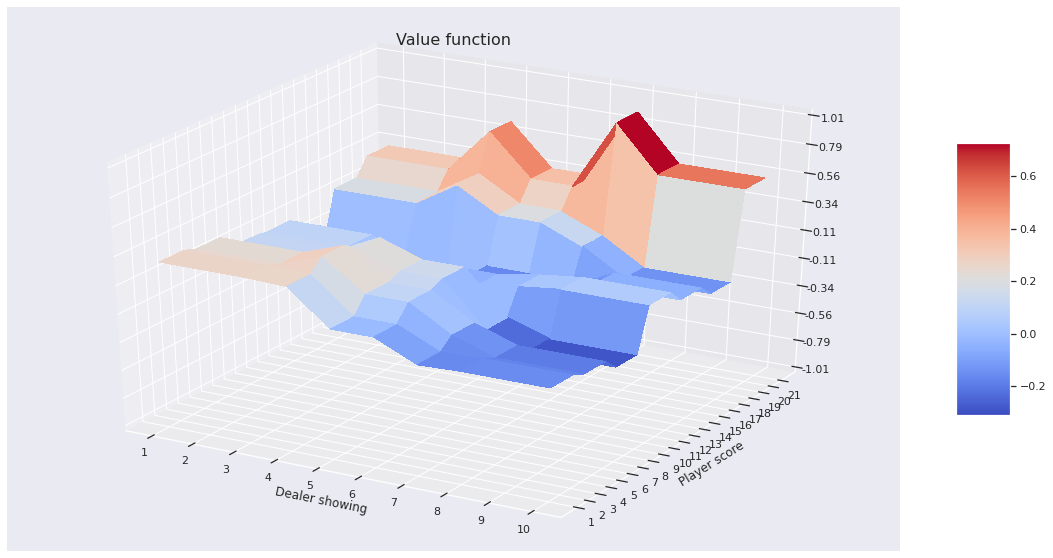

In [ ]:
display(vapol)
plot_table(vavalue)

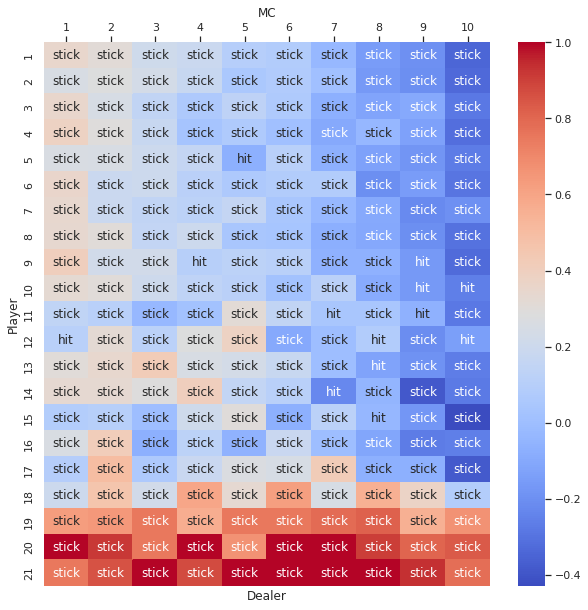

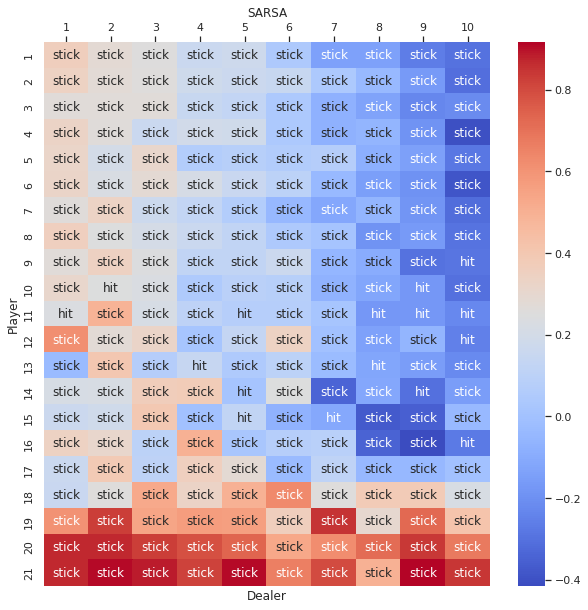

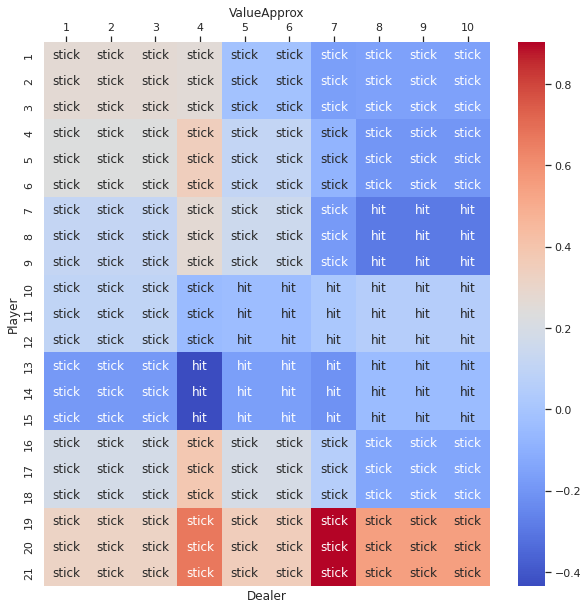

In [ ]:
def plot_graph(policy, value, title):

  policy = policy.values

  dealer_showing = np.arange(1, 11)
  player_score = np.arange(1, 22)

  matrix = pd.DataFrame(value, columns=dealer_showing, index=player_score)

  fig = plt.figure(figsize=(10,10))
  sns.set()
  ax = sns.heatmap(matrix, annot=policy, fmt="s", cmap='coolwarm')
  ax.xaxis.tick_top()
  ax.set_title(title)

  plt.xlabel("Dealer")
  plt.ylabel("Player")

plot_graph(mcpol, mcvalue, "MC")
plot_graph(sarsapol, sarsavalue, "SARSA")
plot_graph(vapol, vavalue, "ValueApprox")